In [11]:
from disentangling.metrics import *
from experiments.utils.seed_everything import seed_everything
import os
import pickle
from experiments.utils.imported_utils import *

In [12]:
DISTRIBUTION = [np.random.uniform, {'low': 0., 'high': 1.}]


In [13]:
def get_factors_codes_decreasing_modularity_compactness(sample_size, num_factors = 6, noise_level= 0.0):
    ''' Create factors-codes dataset

    :param noise_level:     noise level to compute codes from factors
    '''
    # create factors dataset
    dist, dist_kwargs = DISTRIBUTION
    factors = get_artificial_factors_dataset(nb_examples=sample_size, nb_factors=num_factors,
                                             distribution=dist, dist_kwargs=dist_kwargs)

    # create projection matrix
    projection = (1 - noise_level) * np.eye(num_factors) + noise_level * np.eye(num_factors, k=1)
    projection[-1, 0] = noise_level

    # compute codes from continuous factors
    codes = np.dot(factors, projection)

    return factors, codes


In [14]:
def test_metrics(metrics, n_times, samples=[1000, 10000, 20000, 30000]):

    results = {metric.__name__: [] for metric in metrics}  # Initialize results dictionary
    base_path = "results/experiment_complexity"
    os.makedirs(base_path, exist_ok=True)

    for sample_size in samples:
        factors, codes = get_factors_codes_decreasing_modularity_compactness(sample_size)
        sample_results = {metric.__name__: [] for metric in metrics}  # Initialize sample results

        for n in range(n_times):
            seed_everything(n)  # Seed setting for reproducibility

            for metric in metrics:
                start_time = time.time()
                res = metric(factors, codes)                  
                end_time = time.time()
                duration = end_time - start_time
                sample_results[metric.__name__].append(duration)  # Append duration for this run

        # Calculate the average duration across all cases and seeds for each metric
        for metric_name, durations in sample_results.items():
            avg_duration = np.mean(durations)
            results[metric_name].append(avg_duration)  # Corrected to append avg_duration directly

    # Save the results for each metric in individual pickle files
    for metric_name, avg_durations in results.items():
        # Create a dictionary to be pickled with sample sizes as keys and avg_durations as values
        result_dict = {sample_size: avg_duration for sample_size, avg_duration in zip(samples, avg_durations)}
        with open(os.path.join(base_path, f'{metric_name}.pkl'), 'wb') as output_file:
            pickle.dump(result_dict, output_file)

    return results


In [15]:
metrics =  [dci_xgb, mig_ksg, dci, edi]
for metric in metrics:
    df = test_metrics(metrics = [metric], n_times = 1)


KeyboardInterrupt



In [16]:
def plot_curves(plots, output_file, format='png', figsize=(25, 6), x_scale='linear',
                y_scale='linear', x_lims=None, y_lims=(-0.05, 1.05), x_label="", y_label="",
                title_font_size=22, axis_font_size=16, legend_font_size=13, colors=None,
                line_styles=None, legend_positions=None, legend_columns=None):
    ''' Plot curves from a dictionary into the same figure

    :param plots:                   {title: {curves_to_plot}} dictionary
                                    the following format is assumed:
                                    {
                                        title_plot_1:
                                        {
                                            <legend_curve_1>: ([x0, x1, ..., xN], [y0, y1, ..., yN]),
                                            ...
                                        }
                                        ...
                                    }
    :param output_file:             where and under which name the plot is saved
    :param format:                  format to save the plot
    :param figsize:                 size of the figure
    :param x_scale:                 scale on x axis
    :param y_scale:                 scale on y axis
    :param x_lims:                  limit values on x axis
    :param y_lims:                  limit values on y axis
    :param x_label:                 label for the x axis
    :param y_label:                 label for the y axis
    :param title_font_size:         font size for title of each plot
    :param axis_font_size:          font size of axis labels
    :param legend_font_size:        font size of legend labels
    :param colors:                  colors to use for the curves in the plots
    :param line_styles:             line styles to use for the curves in the plot
    :param legend_positions:        positioning of the legend for each plot
    :param legend_columns:          number of columns in the legend for each plot
    '''
    _, axes = plt.subplots(nrows=1, ncols=len(plots), figsize=figsize)

    for idx, title in enumerate(plots):
        # extract legend labels
        curves = plots[title]
        legends = [legend for legend in curves]

        # cycle through colors
        colors_cycle = cycle(colors) if colors is not None else cycle(['blue', 'green', 'red'])
        colors_cycle = [next(colors_cycle) for _ in range(len(curves))]

        # cycle through line styles
        lines_cycle = cycle(line_styles) if line_styles is not None else cycle(['-'])
        lines_cycle = [next(lines_cycle) for _ in range(len(curves))]

        # plot curves
        ax = axes.ravel()[idx]
        for datapoints, legend, color, line_style in zip(curves.values(), legends, colors_cycle, lines_cycle):
            x, y = datapoints  # x: x-values, y: mean values, z: standard deviation
            print(x, y)
            ax.plot(x, y, label=legend, color=color, linestyle=line_style)

#             # Calculate the lower and upper bounds for the standard deviation area
#             lower_bound = y - z
#             upper_bound = y + z

#             # Add the shaded area
#             ax.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.4)  # Adjust alpha for transparency

        # set scales on each axis
        ax.set_xscale(x_scale)
        ax.set_yscale(y_scale)

        # set limits on x and y axis
        if x_lims is not None:
            ax.set_xlim(x_lims[0], x_lims[1])
        if y_lims is not None:
            ax.set_ylim(y_lims[0], y_lims[1])

        # set title and labels on axis
        ax.set_title(title, fontsize=title_font_size, pad=20)
        ax.set_xlabel(x_label, fontsize=axis_font_size)
        ax.set_ylabel(y_label, fontsize=axis_font_size, labelpad=10)

        # set x-ticks and y-ticks font size
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(axis_font_size)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(axis_font_size)

            # set legends
        if legend_positions is not None and legend_columns is not None:
            ax.legend(handlelength=2, loc='lower center', bbox_to_anchor=legend_positions[idx],
                      fontsize=legend_font_size, ncol=legend_columns[idx])
        elif legend_positions is not None:
            ax.legend(handlelength=2, loc='lower center', bbox_to_anchor=legend_positions[idx],
                      fontsize=legend_font_size)
        elif legend_columns is not None:
            ax.legend(handlelength=2, loc='lower center', fontsize=legend_font_size, ncol=legend_columns[idx])
        else:
            ax.legend(handlelength=2, loc='lower center', fontsize=legend_font_size)

    # save the plot
    save_dir = os.path.dirname(output_file)
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f'{output_file}.{format}', bbox_inches='tight', format=format)
    plt.close()


# # METRIC_DICT = {'dcimig': 'DCIMIG', 'dcii Mod': 'DCII Mod', 'dci_xgb Mod': 'DCI Mod', 'dci_xgb Comp': 'DCI Comp', 'dci_xgb Expl': 'DCI Expl', 'mig': 'MIG', 'mig_ksg': 'MIG-ksg', 'mig_sup': 'MIG-sup', 'mig_sup_ksg': 'MIG-sup-ksg', 'dcimig_ksg': 'dcimig-ksg', 'z_min_var': 'FactorVAE', 'sap_xgb': 'SAP', 'modularity': 'Modularity'}
# METRIC_DICT = {'dcimig': 'DCIMIG', 'dcii Mod': 'EDI Mod', 'dcii Comp': 'EDI Comp', 'dcii Expl':'EDI Expl', 'dci_xgb Mod': 'DCI Mod', 'dci_xgb Comp': 'DCI Comp', 'dci_xgb Expl': 'DCI Expl', 'mig': 'MIG', 'mig_ksg': 'MIG-ksg', 'mig_sup': 'MIG-sup', 'mig_sup_ksg': 'MIG-sup-ksg', 'dcimig_ksg': 'dcimig-ksg', 'z_min_var': 'FactorVAE', 'sap_xgb': 'SAP', 'modularity': 'Modularity'}

# # config parameters for plots
# loosely_dashed = (0, (5, 10))
# densely_dashdotdotted = (0, (3, 1, 1, 1, 1, 1))
# densely_dotted = (0, (1, 1))
# PLOTS = {


#     'COLORS': ['blue', 'green', 'red', 'darkturquoise', 'magenta', 'orange', 'black', 'violet', 'maroon'],
#     'LINE STYLES': ['--', '-.', loosely_dashed, densely_dashdotdotted, ':', densely_dotted],
#     'LEGEND POSITIONS': [(0.5, -0.2)],
#     'NB LEGEND COLUMNS': [ 5, 5]
# }

METRIC_DICT_complexity = {dci_xgb: 'DCI-xgb', dcimig: 'DCIMIG', edi: 'EDI', dci: 'DCI', mig: 'MIG', mig_ksg: 'MIG-ksg', mig_sup: 'MIG-sup', mig_sup_ksg: 'MIG-sup-ksg', dcimig_ksg: 'dcimig-ksg', z_min_var: 'FactorVAE', sap: 'SAP', modularity: 'Modularity'}
METRIC_DICT = {'dcimig': 'DCIMIG', 'dcii Mod': 'EDI Mod', 'dcii Comp': 'EDI Comp', 'dcii Expl':'EDI Expl', 'dci_xgb Mod': 'DCI Mod', 'dci_xgb Comp': 'DCI Comp', 'dci_xgb Expl': 'DCI Expl', 'mig': 'MIG', 'mig_ksg': 'MIG-ksg', 'mig_sup': 'MIG-sup', 'mig_sup_ksg': 'MIG-sup-ksg', 'dcimig_ksg': 'dcimig-ksg', 'z_min_var': 'FactorVAE', 'sap_xgb': 'SAP', 'modularity': 'Modularity'}

loosely_dashed = (0, (5, 10))
densely_dashdotdotted = (0, (3, 1, 1, 1, 1, 1))
densely_dotted = (0, (1, 1))
dash_dotted = (0, (3, 5, 1, 5))
long_dashed = (0, (5, 5))
short_dashed = (0, (5, 1))

PLOTS = {
    
        'FAMILIES': {
        'Metrics': [ 'mig'],
      
        
    },
    'COLORS': [
        'blue', 'green', 'red', 'darkturquoise', 'magenta', 
        'orange', 'black', 'violet', 'maroon', 'lightgreen', 
        'mint', 'cyan', 'brown', 'pink', 'lime', 'yellow'
    ],
    'LINE STYLES': [
        '--', '-.', loosely_dashed, densely_dashdotdotted, ':', 
        densely_dotted, dash_dotted, long_dashed, short_dashed, 
        (0, (1, 10)), (0, (5, 10)), (0, (3, 10, 1, 10))
    ],
    'LEGEND POSITIONS': [(0.5, -0.15)],
    'NB LEGEND COLUMNS': [5]  # Adjusted for improved layout
}




In [17]:
# plot_scores():
#     output_dir = "results/experiment_complexity/"
#     scores = {}

#     # Load metric scores from pickle files
#     metric_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]
#     for file in metric_files:
#         metric_name = os.path.splitext(file)[0]  # Get the file name without the extension
#         with open(os.path.join(output_dir, file), 'rb') as f:
#             metric_scores = pickle.load(f)
#         scores[metric_name] = metric_scores

#     # Initialize a figure for plotting
#     plt.figure(figsize=(10, 6))

#     # A counter to keep track of which metric we're plotting for color and line style
#     metric_counter = 0

#     # Preparing data for plotting
#     for metric_name, metric_scores in scores.items():
#         print(metric_scores)
#         sample_sizes = list(metric_scores.keys())
#         values = list(metric_scores.values())
#         display_name = METRIC_DICT[globals()[metric_name]] # Get the display name
#         color = PLOTS['COLORS'][metric_counter % len(PLOTS['COLORS'])]
#         line_style = PLOTS['LINE STYLES'][metric_counter % len(PLOTS['LINE STYLES'])]

#         plt.plot(sample_sizes, values, label= display_name, color=color, linestyle=line_style)
#         metric_counter += 1

#     # Customizing the plot
#     plt.xlabel('Sample Size')
#     plt.ylabel('Duration (seconds)')
#     plt.title('Time Complexity Analysis')
#     plt.xscale('log')  # Applying logarithmic scale
#     plt.xlim(left=1000, right=25000)
#     plt.ylim(bottom = 0, top = 2000)
#     # Adjust xlim and ylim as necessary, based on your data

#     # Customizing legend with positions and columns
#     legend_position = PLOTS['LEGEND POSITIONS'][0]
#     nb_legend_columns = PLOTS['NB LEGEND COLUMNS'][0]
#     plt.legend(loc='upper center', bbox_to_anchor=legend_position, ncol=nb_legend_columns)

#     # Save and show the plot
#     plt.savefig(os.path.join(output_dir, 'experiment_complexity.png'))
#     # plt.savefig(os.path.join(output_dir, 'experiment_complexity.eps'))

#     plt.show()

In [18]:
def plot_scores(output_dir="results/experiment_complexity/"):
    scores = {}

    # Load metric scores from pickle files
    metric_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]
    for file in metric_files:
        metric_name = os.path.splitext(file)[0]  # Get the file name without the extension
        with open(os.path.join(output_dir, file), 'rb') as f:
            metric_scores = pickle.load(f)
        scores[metric_name] = metric_scores

    # Initialize a figure for plotting
    plt.figure(figsize=(10, 6))
    metric_counter = 0

    # Preparing data for plotting
    for metric_name, metric_scores in scores.items():
        sample_sizes = list(metric_scores.keys())
        values = list(metric_scores.values())
        display_name = METRIC_DICT[globals()[metric_name]]  # Get the display name
        color = PLOTS['COLORS'][metric_counter % len(PLOTS['COLORS'])]
        line_style = PLOTS['LINE STYLES'][metric_counter % len(PLOTS['LINE STYLES'])]

        plt.plot(sample_sizes, values, label=display_name, color=color, linestyle=line_style)
        metric_counter += 1
    # Customizing the plot
    plt.xlabel('Sample Size', fontsize=axis_font_size)  # Adjust label font size
    plt.ylabel('Duration (seconds)', fontsize=axis_font_size)  # Adjust label font size
    plt.title('Time Complexity Analysis', fontsize=title_font_size)  # Adjust title font size
    plt.xscale('log')  # Applying logarithmic scale
    plt.xlim(left=1000, right=25000)
    plt.ylim(bottom=0, top=2000)
    # Adjust xlim and ylim as necessary, based on your data

    # Customizing legend with positions and columns
    legend_position = PLOTS['LEGEND POSITIONS'][0]
    nb_legend_columns = PLOTS['NB LEGEND COLUMNS'][0]
    plt.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=legend_font_size)  # Adjust legend font size

    # Save and show the plot
    plt.savefig(os.path.join(output_dir, 'experiment_complexity.png'))
    # plt.savefig(os.path.join(output_dir, 'experiment_complexity.eps'))

    plt.show()

SyntaxError: invalid syntax (740044962.py, line 38)

In [19]:
plot_scores()

NameError: name 'plot_scores' is not defined

In [56]:
METRIC_DICT[globals()['dci_xgb']]

'DCI_RF'

In [54]:
globals()'dci'

SyntaxError: invalid syntax (320525269.py, line 1)

In [116]:
title_font_size = 20
axis_font_size = 18
legend_font_size = 14

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [2]:
import os
import pickle
import matplotlib.pyplot as plt

def plot_scores1(output_dir="results/experiment_sample_efficiency/"):
    scores = {}

    # Load metric scores from pickle files
    metric_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.pkl')]
    for metric_file in metric_files:
        with open(metric_file, 'rb') as f:
            metric_scores = pickle.load(f)
        scores.update(metric_scores)
    
    # Initialize a figure for plotting
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))  # Create a grid of 1 row and 2 columns for the subplots

    # Plotting the first figure
    metric_counter = 0
    for metric_name, (sample_sizes, values) in scores.items():
        display_name = METRIC_DICT.get(metric_name, metric_name)
        color = PLOTS['COLORS'][metric_counter % len(PLOTS['COLORS'])]
        line_style = PLOTS['LINE STYLES'][metric_counter % len(PLOTS['LINE STYLES'])]
        
        ax[0].plot(sample_sizes, values, label=display_name, color=color, linestyle=line_style, linewidth = 2.0)
        metric_counter += 1

    # Customizing the first plot
    ax[0].set_xlabel('Sample Size', fontsize=axis_font_size)
    ax[0].set_ylabel('Score', fontsize=axis_font_size)
    ax[0].set_title('Sample Efficiency', fontsize=title_font_size)
    ax[0].set_xscale('log')
    ax[0].set_xlim(left=100, right=100000)
    ax[0].set_ylim(bottom=0, top=0.35)
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=legend_font_size)

    # Plotting the second figure
    scores = {}
    output_dir = "results/experiment_complexity/"
    metric_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]
    for file in metric_files:
        metric_name = os.path.splitext(file)[0]
        with open(os.path.join(output_dir, file), 'rb') as f:
            metric_scores = pickle.load(f)
        scores[metric_name] = metric_scores

    metric_counter = 0
    for metric_name, metric_scores in scores.items():
        sample_sizes = list(metric_scores.keys())
        values = list(metric_scores.values())
        display_name = METRIC_DICT_complexity[globals()[metric_name]]
        color = PLOTS['COLORS'][metric_counter % len(PLOTS['COLORS'])]
        line_style = PLOTS['LINE STYLES'][metric_counter % len(PLOTS['LINE STYLES'])]

        ax[1].plot(sample_sizes, values, label=display_name, color=color, linestyle=line_style, linewidth = 2.0)
        metric_counter += 1

    # Customizing the second plot

    ax[1].set_xlabel('Sample Size', fontsize=axis_font_size)
    ax[1].set_ylabel('Duration (seconds)', fontsize=axis_font_size)
    ax[1].set_title('Time Complexity', fontsize=title_font_size)
    ax[1].set_xscale('log')
    ax[1].set_xlim(left=1000, right=25000)
    ax[1].set_ylim(bottom=0, top=2000)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=legend_font_size)

    # Save and show the plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'experiment_combined_efficiency_complexity.png'))
    plt.show()


NameError: name 'METRIC_DICT' is not defined

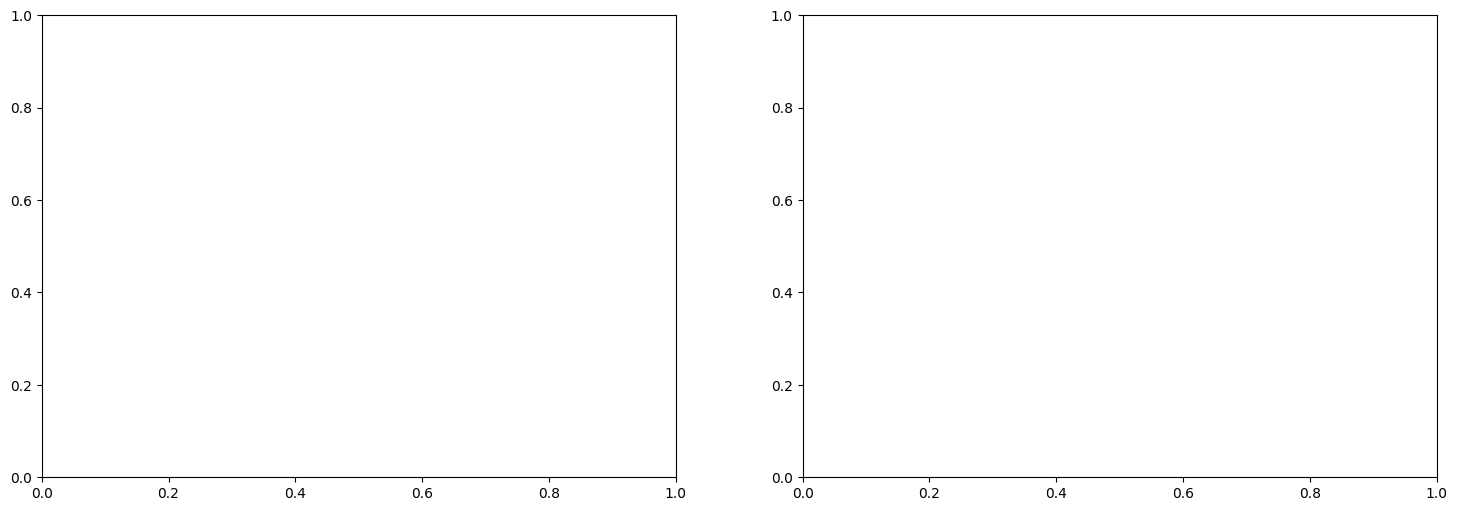

In [7]:
plot_scores1()

In [6]:
cd ..

/home/InnVariant
